# Load Libraries & Import Data

In [62]:
# Load libraries
import numpy as np
import scipy as sp

import pandas as pd
from pandas.tools.plotting import scatter_matrix

import IPython
from IPython import display

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize']=12,8

import warnings
warnings.filterwarnings('ignore')

In [63]:
# Import Data
###import os
###print(os.listdir("../input"))

df_train = pd.read_csv("../input/train.csv")
df_val = pd.read_csv("../input/test.csv")

# Look at data
print(df_train.info())
df_train.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
44,45,1,3,"Devaney, Miss. Margaret Delia",female,19.0,0,0,330958,7.8792,NaN,Q
854,855,0,2,"Carter, Mrs. Ernest Courtenay (Lilian Hughes)",female,44.0,1,0,244252,26.0000,NaN,S
856,857,1,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45.0,1,1,36928,164.8667,NaN,S
455,456,1,3,"Jalsevac, Mr. Ivan",male,29.0,0,0,349240,7.8958,NaN,C
347,348,1,3,"Davison, Mrs. Thomas Henry (Mary E Finck)",female,NaN,1,0,386525,16.1000,NaN,S
625,626,0,1,"Sutton, Mr. Frederick",male,61.0,0,0,36963,32.3208,D50,S
490,491,0,3,"Hagland, Mr. Konrad Mathias Reiersen",male,NaN,1,0,65304,19.9667,NaN,S
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C
664,665,1,3,"Lindqvist, Mr. Eino William",male,20.0,1,0,STON/O 2. 3101285,7.9250,NaN,S
708,709,1,1,"Cleaver, Miss. Alice",female,22.0,0,0,113781,151.5500,NaN,S


In [64]:
# Get list of all features
features = df_train.columns.tolist()
print('Features:')
features

Features:


['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [65]:
# Describe features
df_train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Lundahl, Mr. Johan Svensson",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [66]:
# Make sure there are no duplicate ids
idsUnique = len(set(df_train.PassengerId))
idsTotal = df_train.shape[0]
idsDup = idsTotal - idsUnique
if idsDup>0: print('DUPLICATE IDS FOUND')

# Remove ID column from dataframe
train_IDs = df_train.PassengerId
df_train.drop('PassengerId', axis=1, inplace=True)
val_IDs = df_val.PassengerId
df_val.drop('PassengerId', axis=1, inplace=True)
features.remove('PassengerId')

# Print dataframe sizes
print('Passenger ID column dropped')
print('Training dataframe: ', df_train.shape)
print('Testing dataframe: ', df_val.shape)    

Passenger ID column dropped
Training dataframe:  (891, 11)
Testing dataframe:  (418, 10)


In [67]:
# Store target data as separate DF
df_target = df_train['Survived']
#df_train.drop(['Survived'], axis=1, inplace=True)

# Save number of elements in each group
ntrain = df_train.shape[0]
nval = df_val.shape[0]

#combine data for cleaning
data_cleaner = [df_train, df_val]

# Fill in Missing Data

In [68]:
# Find null values
print('Training Data null values:\n', df_train.isnull().sum())
print('\n\n')
print('Validation Data null values: \n', df_val.isnull().sum())

Training Data null values:
 Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64



Validation Data null values: 
 Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64


In [69]:
# Deal with missing data
for dataset in data_cleaner:
    ## age: use median
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)
    ## embarked: use mode
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace=True)
    ## Fare:  use median
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace=True)
    ## Cabin: was cabin assigned
    dataset.loc[:,'Cabin'] = dataset.Cabin.notnull().map({True: 1, False:0})
    ## Ticket: Extract number
    ticket_array = dataset['Ticket'].str.split(' ')
    for index, row in ticket_array.iteritems():
        try: dataset.loc[index, 'Ticket']=int(row[-1])
        except: dataset.loc[index, 'Ticket']=0
    pd.to_numeric(dataset['Ticket'], errors='coerce')

# Check that all missing data is filled
print('Training Data null values:\n', df_train.isnull().sum())
print('\n\n')
print('Validation Data null values: \n', df_val.isnull().sum())

Training Data null values:
 Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
dtype: int64



Validation Data null values: 
 Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
dtype: int64


# Feature Engineering

In [70]:
# Make new features
for dataset in data_cleaner:
    ## Family size
    dataset['Family'] = dataset['SibSp'] + dataset['Parch'] + 1
    ## Tag for traveling alone
    dataset['Alone']=1
    dataset['Alone'].loc[dataset['Family']>1]=0
    
    ## Title
    dataset['Title'] = dataset['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]    
## Check title distributions
print('Training Titles')
print(df_train['Title'].value_counts())
print('Testing Titles')
print(df_val['Title'].value_counts())

Training Titles
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Lady              1
Sir               1
Ms                1
Jonkheer          1
Mme               1
the Countess      1
Don               1
Capt              1
Name: Title, dtype: int64
Testing Titles
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: Title, dtype: int64


In [71]:
# Simplify Title Names
# a map of more aggregated titles
Title_Dictionary = {    
                    "Mr":       "Mr",
                    "Miss":     "Miss",
                    "Mrs":      "Mrs",
                    "Master":   "Master",  
                    "Dr":       "Crew",
                    "Rev":      "Crew",
                    "Col":      "Crew",
                    "Mlle":     "Miss",
                    "Major":    "Crew",
                    "Ms":       "Mrs",
                    "Don":      "Royalty", 
                    "Dona":     "Royalty",
                    "Lady":     "Royalty",
                    "the Countess":   "Royalty",
                    "Sir":      "Royalty",
                    "Mme":      "Mrs",
                    "Capt":     "Crew", 
                    "Jonkheer": "Crew",
                    }

# we map each title
for dataset in data_cleaner:
    dataset[ 'Title' ] = dataset.Title.map( Title_Dictionary )
    
## Check title distributions
print('Training Titles')
print(df_train['Title'].value_counts())
print('Testing Titles')
print(df_val['Title'].value_counts())

Training Titles
Mr         517
Miss       184
Mrs        127
Master      40
Crew        19
Royalty      4
Name: Title, dtype: int64
Testing Titles
Mr         240
Miss        78
Mrs         73
Master      21
Crew         5
Royalty      1
Name: Title, dtype: int64


In [72]:
# Look at data
df_train.sample(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Alone,Title
210,0,3,"Ali, Mr. Ahmed",male,24.0,0,0,3101311,7.0500,0,S,1,1,Mr
96,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,17754,34.6542,1,C,1,1,Mr
413,0,2,"Cunningham, Mr. Alfred Fleming",male,28.0,0,0,239853,0.0000,0,S,1,1,Mr
552,0,3,"O'Brien, Mr. Timothy",male,28.0,0,0,330979,7.8292,0,Q,1,1,Mr
151,1,1,"Pears, Mrs. Thomas (Edith Wearne)",female,22.0,1,0,113776,66.6000,1,S,2,0,Mrs
751,1,3,"Moor, Master. Meier",male,6.0,0,1,392096,12.4750,1,S,2,0,Master
299,1,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.0,0,1,17558,247.5208,1,C,2,0,Mrs
832,0,3,"Saad, Mr. Amin",male,28.0,0,0,2671,7.2292,0,C,1,1,Mr
80,0,3,"Waelens, Mr. Achille",male,22.0,0,0,345767,9.0000,0,S,1,1,Mr
98,1,2,"Doling, Mrs. John T (Ada Julia Bone)",female,34.0,0,1,231919,23.0000,0,S,2,0,Mrs


# Data Exploration

In [73]:
temp_list = ['Pclass','Sex','SibSp','Parch','Embarked', 'Title', 'Family', 'Alone']
for feature in temp_list:
    print('Survival Correlation by: ', feature)
    print (df_train[[feature, 'Survived']].groupby([feature], as_index=False).mean().sort_values(by='Survived', ascending=False))
    print ('\n')

Survival Correlation by:  Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


Survival Correlation by:  Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908


Survival Correlation by:  SibSp
   SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000


Survival Correlation by:  Parch
   Parch  Survived
3      3  0.600000
1      1  0.550847
2      2  0.500000
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000


Survival Correlation by:  Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


Survival Correlation by:  Title
     Title  Survived
4      Mrs  0.795276
5  Royalty  0.750000
2     Miss  0.701087
1   Master  0.575000
0     Crew  0.263158
3       Mr  0.156673


Survival Correlation by:  Family
   Family  Survived
3       4  0.724138
2       3  0.578431
1       2  0.552795
6     

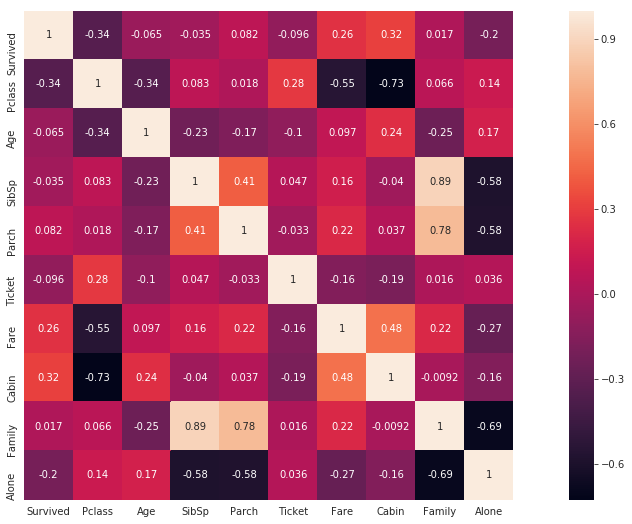

In [74]:
# Coorelation plot
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(20,9))
sns.heatmap(corrmat, square=True, annot=True)

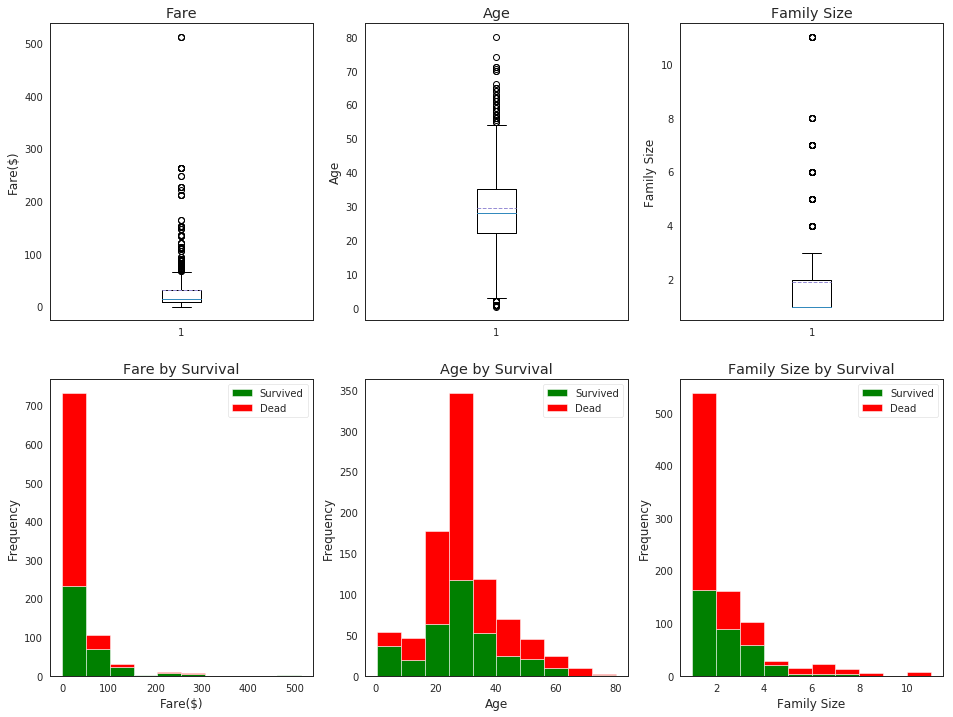

In [75]:
## Quanitative Data
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=df_train['Fare'], showmeans = True, meanline=True)
plt.title('Fare')
plt.ylabel('Fare($)')

plt.subplot(232)
plt.boxplot(x=df_train['Age'], showmeans = True, meanline=True)
plt.title('Age')
plt.ylabel('Age')

plt.subplot(233)
plt.boxplot(x=df_train['Family'], showmeans = True, meanline=True)
plt.title('Family Size')
plt.ylabel('Family Size')

plt.subplot(234)
plt.hist(x=[df_train[df_train['Survived']==1]['Fare'], df_train[df_train['Survived']==0]['Fare']],
         stacked = True, color = ['g','r'], label=['Survived', 'Dead'])
plt.title('Fare by Survival')
plt.xlabel('Fare($)')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(235)
plt.hist(x=[df_train[df_train['Survived']==1]['Age'], df_train[df_train['Survived']==0]['Age']],
         stacked = True, color = ['g','r'], label=['Survived', 'Dead'])
plt.title('Age by Survival')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(236)
plt.hist(x=[df_train[df_train['Survived']==1]['Family'], df_train[df_train['Survived']==0]['Family']],
         stacked = True, color = ['g','r'], label=['Survived', 'Dead'])
plt.title('Family Size by Survival')
plt.xlabel('Family Size')
plt.ylabel('Frequency')
plt.legend()

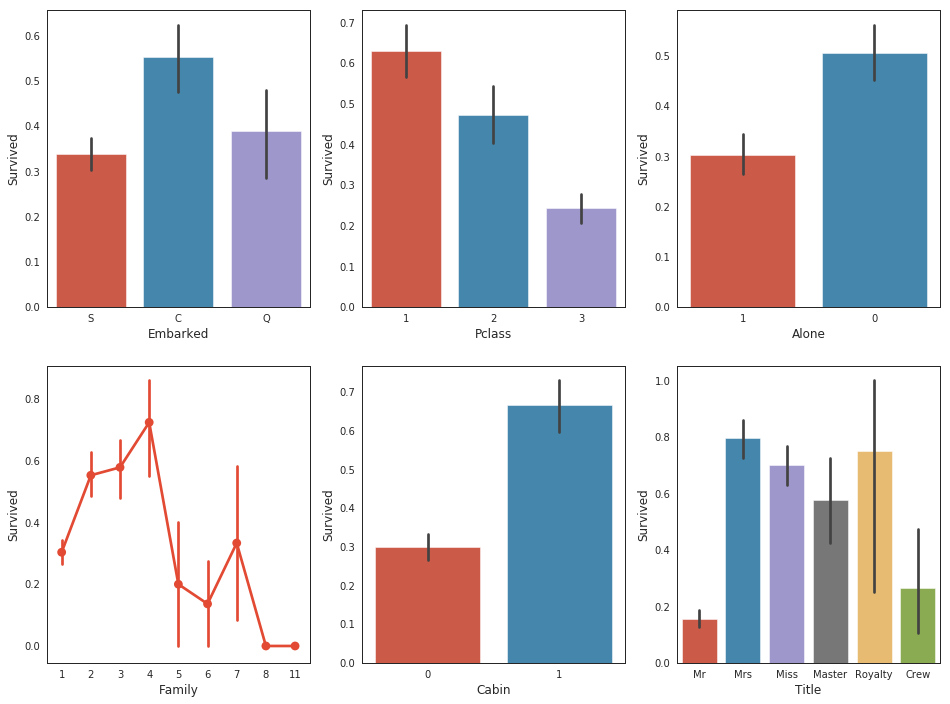

In [76]:
## Feature dependencies on Survival
fig, saxis = plt.subplots(2, 3, figsize=(16,12))
sns.barplot(x='Embarked', y = 'Survived', data=df_train, ax=saxis[0,0])
sns.barplot(x='Pclass', y='Survived', order=[1,2,3], data=df_train, ax=saxis[0,1])
sns.barplot(x='Alone', y='Survived', order=[1,0], data=df_train, ax=saxis[0,2])
sns.pointplot(x='Family', y='Survived', data=df_train, ax=saxis[1,0])
sns.barplot(x='Cabin', y='Survived', data=df_train, ax=saxis[1,1])
sns.barplot(x='Title', y='Survived', data=df_train, ax=saxis[1,2])

Text(0.5,1,'Class v Family Size Survival')

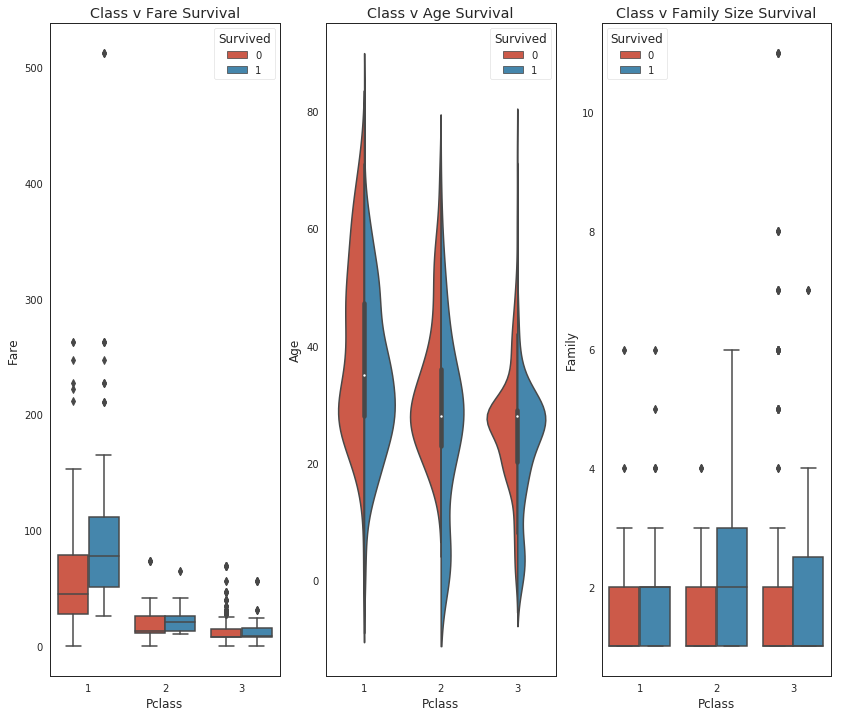

In [77]:
## Class Dependencies
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(14,12))

sns.boxplot(x='Pclass', y='Fare', hue='Survived', data=df_train, ax=axis1)
axis1.set_title('Class v Fare Survival')

sns.violinplot(x='Pclass', y='Age', hue='Survived', data=df_train, split = True, ax=axis2)
axis2.set_title('Class v Age Survival')

sns.boxplot(x='Pclass', y='Family', hue='Survived', data=df_train, ax=axis3)
axis3.set_title('Class v Family Size Survival')

Text(0.5,1,'Sex v Alone Survival')

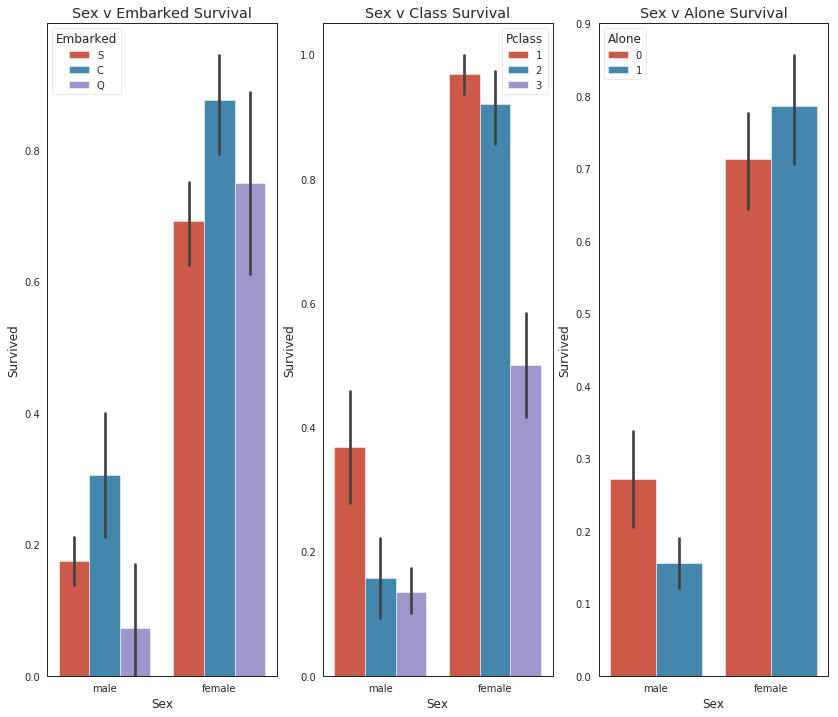

In [78]:
## Gender Dependencies

fig, qaxis = plt.subplots(1,3,figsize=(14,12))

sns.barplot(x='Sex', y='Survived', hue='Embarked', data=df_train, ax=qaxis[0])
qaxis[0].set_title('Sex v Embarked Survival')

sns.barplot(x='Sex', y='Survived', hue='Pclass', data=df_train, ax=qaxis[1])
qaxis[1].set_title('Sex v Class Survival')

sns.barplot(x='Sex', y='Survived', hue='Alone', data=df_train, ax=qaxis[2])
qaxis[2].set_title('Sex v Alone Survival')

Text(0.5,1,'Class Survival by Sex')

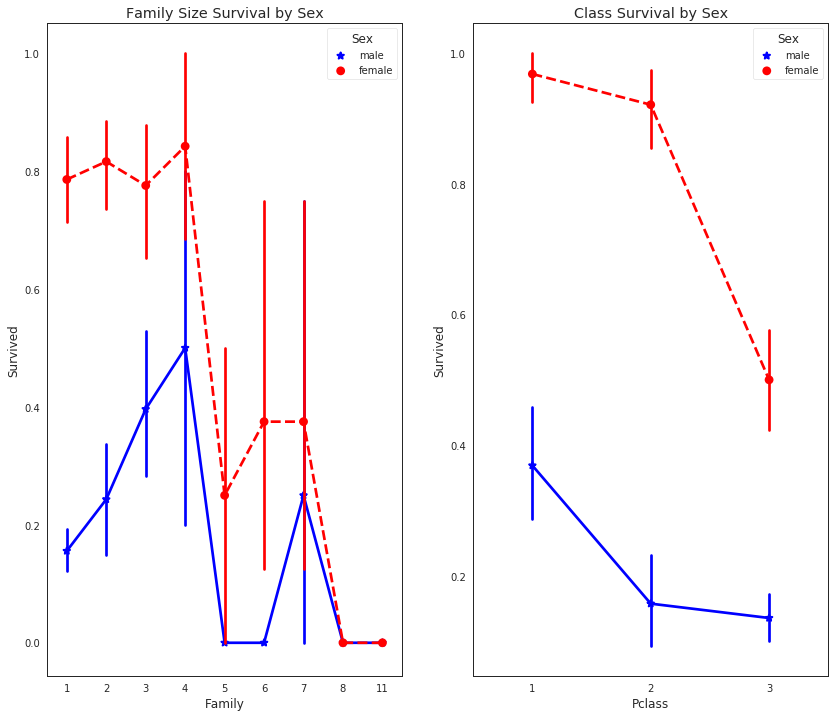

In [79]:
fig, (maxis1, maxis2) = plt.subplots(1, 2,figsize=(14,12))

sns.pointplot(x="Family", y="Survived", hue="Sex", data=df_train,
              palette={"male": "blue", "female": "red"},
              markers=["*", "o"], linestyles=["-", "--"], ax = maxis1)
maxis1.set_title('Family Size Survival by Sex')

sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=df_train,
              palette={"male": "blue", "female": "red"},
              markers=["*", "o"], linestyles=["-", "--"], ax = maxis2)
maxis2.set_title('Class Survival by Sex')

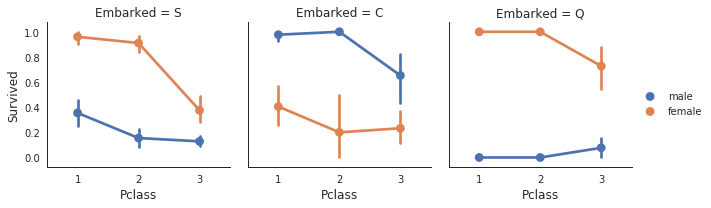

In [80]:
## Embark Dependencies
e = sns.FacetGrid(df_train, col='Embarked')
e.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', ci=95.0, palette='deep')
e.add_legend()

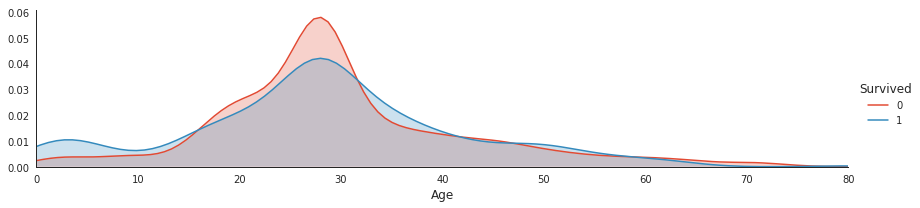

In [81]:
## Age Dependencies
a=sns.FacetGrid(df_train, hue='Survived', aspect=4)
a.map(sns.kdeplot, 'Age', shade=True)
a.set(xlim=(0, df_train['Age'].max()))
a.add_legend()

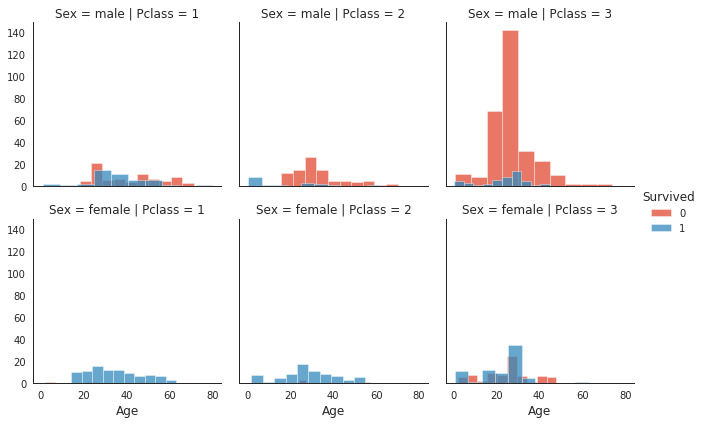

In [82]:
h=sns.FacetGrid(df_train, row='Sex', col='Pclass', hue='Survived')
h.map(plt.hist, 'Age', alpha=0.75)
h.add_legend()

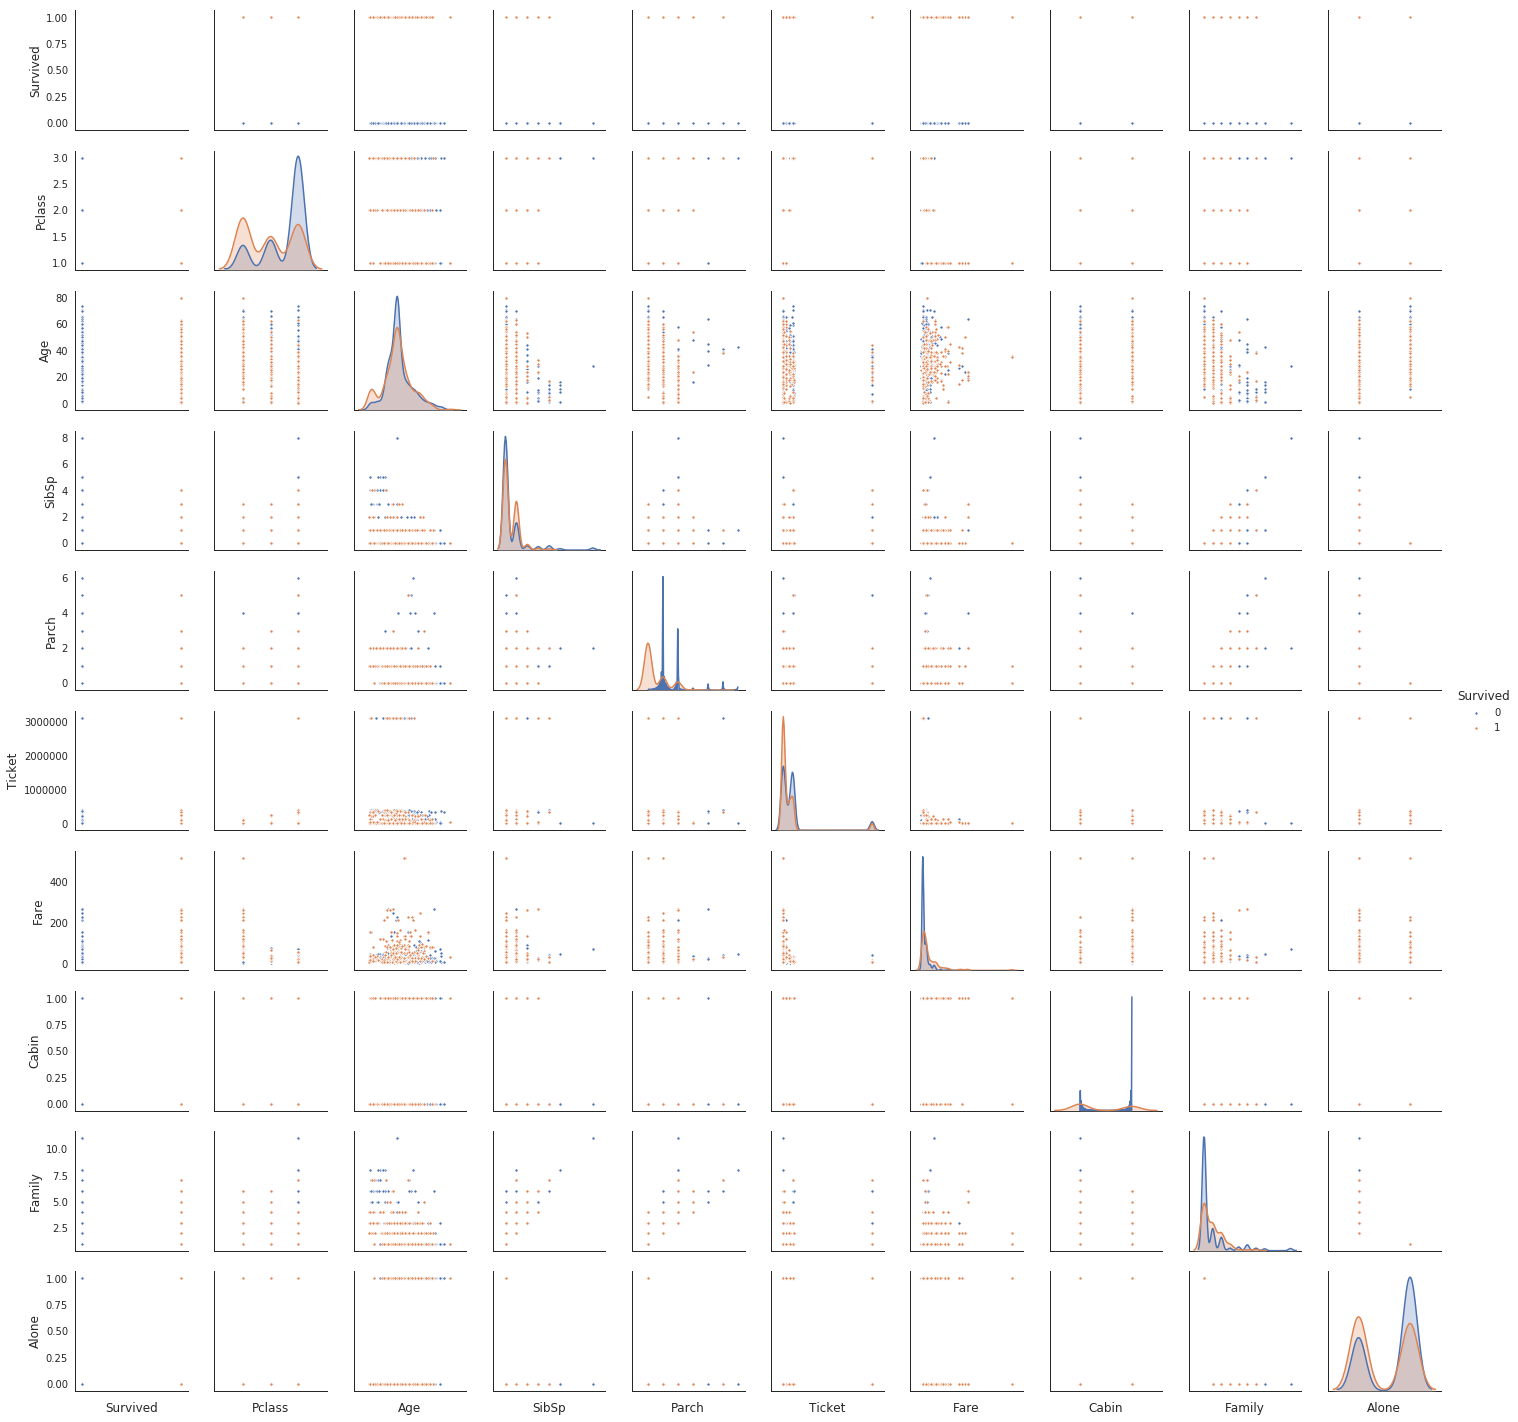

In [83]:
## Pairplot of all features
pp=sns.pairplot(df_train, hue='Survived', palette='deep', size=2, 
                diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
pp.set(xticklabels=[])

# Bin Age and Fare Features

In [84]:
# Make new features
for dataset in data_cleaner:
    ## Bin Fare by frequency
    dataset['FareBin']=pd.qcut(dataset['Fare'], 4)
    ## Bin Age by value
    dataset['AgeBin']=pd.cut(dataset['Age'].astype(int), 5)
    

# Final Feature Selection and Encoding

In [85]:
df_train.columns.tolist()

['Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked',
 'Family',
 'Alone',
 'Title',
 'FareBin',
 'AgeBin']

In [86]:
# Encode Data
label = LabelEncoder()
for dataset in data_cleaner:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])

# get dummies for training data
embark_codes = pd.get_dummies(df_train['Embarked'], prefix='Embarked')
title_codes = pd.get_dummies(df_train['Title'], prefix = 'Title')  
df_train = pd.concat([df_train, embark_codes, title_codes], axis=1)

# get dummies for testing data
embark_codes = pd.get_dummies(df_val['Embarked'], prefix='Embarked')
title_codes = pd.get_dummies(df_val['Title'], prefix = 'Title')  
df_val = pd.concat([df_val, embark_codes, title_codes], axis=1)
   
df_train.sample(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Alone,Title,FareBin,AgeBin,Sex_Code,AgeBin_Code,FareBin_Code,Embarked_C,Embarked_Q,Embarked_S,Title_Crew,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Royalty
750,1,2,"Wells, Miss. Joan",female,4.00,1,1,29103,23.0000,0,S,3,0,Miss,"(14.454, 31.0]","(-0.08, 16.0]",0,0,2,0,0,1,0,0,1,0,0,0
153,0,3,"van Billiard, Mr. Austin Blyler",male,40.50,0,2,851,14.5000,0,S,3,0,Mr,"(14.454, 31.0]","(32.0, 48.0]",1,2,2,0,0,1,0,0,0,1,0,0
320,0,3,"Dennis, Mr. Samuel",male,22.00,0,0,21172,7.2500,0,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]",1,1,0,0,0,1,0,0,0,1,0,0
175,0,3,"Klasen, Mr. Klas Albin",male,18.00,1,1,350404,7.8542,0,S,3,0,Mr,"(-0.001, 7.91]","(16.0, 32.0]",1,1,0,0,0,1,0,0,0,1,0,0
287,0,3,"Naidenoff, Mr. Penko",male,22.00,0,0,349206,7.8958,0,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]",1,1,0,0,0,1,0,0,0,1,0,0
304,0,3,"Williams, Mr. Howard Hugh ""Harry""",male,28.00,0,0,2466,8.0500,0,S,1,1,Mr,"(7.91, 14.454]","(16.0, 32.0]",1,1,1,0,0,1,0,0,0,1,0,0
835,1,1,"Compton, Miss. Sara Rebecca",female,39.00,1,1,17756,83.1583,1,C,3,0,Miss,"(31.0, 512.329]","(32.0, 48.0]",0,2,3,1,0,0,0,0,1,0,0,0
577,1,1,"Silvey, Mrs. William Baird (Alice Munger)",female,39.00,1,0,13507,55.9000,1,S,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]",0,2,3,0,0,1,0,0,0,0,1,0
469,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,0,C,4,0,Miss,"(14.454, 31.0]","(-0.08, 16.0]",0,0,2,1,0,0,0,0,1,0,0,0
247,1,2,"Hamalainen, Mrs. William (Anna)",female,24.00,0,2,250649,14.5000,0,S,3,0,Mrs,"(14.454, 31.0]","(16.0, 32.0]",0,1,2,0,0,1,0,0,0,0,1,0


In [87]:
df_train.columns.tolist()

['Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked',
 'Family',
 'Alone',
 'Title',
 'FareBin',
 'AgeBin',
 'Sex_Code',
 'AgeBin_Code',
 'FareBin_Code',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Title_Crew',
 'Title_Master',
 'Title_Miss',
 'Title_Mr',
 'Title_Mrs',
 'Title_Royalty']

In [88]:
# Define Features and Target
Target = ['Survived']

## Features List
features = [
     'Pclass',
     'SibSp',
     'Parch',
     'Family',
     'Alone',
     'Sex_Code',
     'AgeBin_Code',
     'FareBin_Code',
     'Embarked_C',
     'Embarked_Q',
     'Embarked_S',
     'Title_Crew',
     'Title_Master',
     'Title_Miss',
     'Title_Mr',
     'Title_Mrs',
     'Title_Royalty']

# Models

In [89]:
# Split Data for training
y=df_train[Target]
X=df_train[features]

#X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=0)

#print('Original: {}'.format(df_train.shape))
#print('Train: {}'.format(X_train.shape))
#print('Test: {}'.format(X_test.shape))

# Split Data for Cross Validation
cv_split = model_selection.ShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=0)
# throw out 10% of data for each split

In [90]:
# Machine Learning Algorithms for Classification
MLA = [
    ## Ensemble
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    ## Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    ## Generalized Linear Models (GLM)
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    ## Naive Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    ## Nearest Neighbots
    neighbors.KNeighborsClassifier(),
    
    ## Support Vector Machines (SVM)
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    ## Decision Trees
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    ## Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    #xgboost
    XGBClassifier()
        
]

# Set up dataframe to hold Machine Learning Results
MLA_columns = ['Name', 'Parameters', 'Train Accuracy (Mean)', 'Test Accuracy (Mean)',
              'Test Accuracy (3 STD)', 'Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

MLA_predict = y.copy(deep=True)

In [91]:
# Test all MLA methods in list
row_index = 0
for alg in MLA:
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'Name']=MLA_name
    MLA_compare.loc[row_index, 'Parameters'] = str(alg.get_params())
    
    cv_results = model_selection.cross_validate(alg, X, y, cv = cv_split)
    MLA_compare.loc[row_index, 'Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'Train Accuracy (Mean)'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'Test Accuracy (Mean)'] = cv_results['test_score'].mean()
    MLA_compare.loc[row_index, 'Test Accuracy (3 STD)'] = cv_results['test_score'].std()*3
    
    alg.fit(X, y)
    MLA_predict[MLA_name] = alg.predict(X)
    
    row_index += 1

MLA_compare.sort_values(by=['Test Accuracy (Mean)'], ascending = False, inplace = True)
MLA_compare

,Name,Parameters,Train Accuracy (Mean),Test Accuracy (Mean),Test Accuracy (3 STD),Time
14,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.832772,0.828358,0.0505594,0.0583883
21,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.856929,0.827985,0.0434842,0.0338369
15,NuSVC,"{'cache_size': 200, 'class_weight': None, 'coe...",0.830337,0.827239,0.0469749,0.0713892
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.894195,0.826866,0.0673877,0.0173285
16,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.832584,0.825746,0.0517958,0.0319849
19,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.831273,0.822761,0.0571334,0.00417173
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.852434,0.822388,0.0868818,0.00239108
8,RidgeClassifierCV,"{'alphas': (0.1, 1.0, 10.0), 'class_weight': N...",0.831273,0.821642,0.0545644,0.013118
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.871723,0.819776,0.0513097,0.077519
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.827715,0.81791,0.0604478,0.258671


Text(0.5,0,'Accuracy Score (%)')

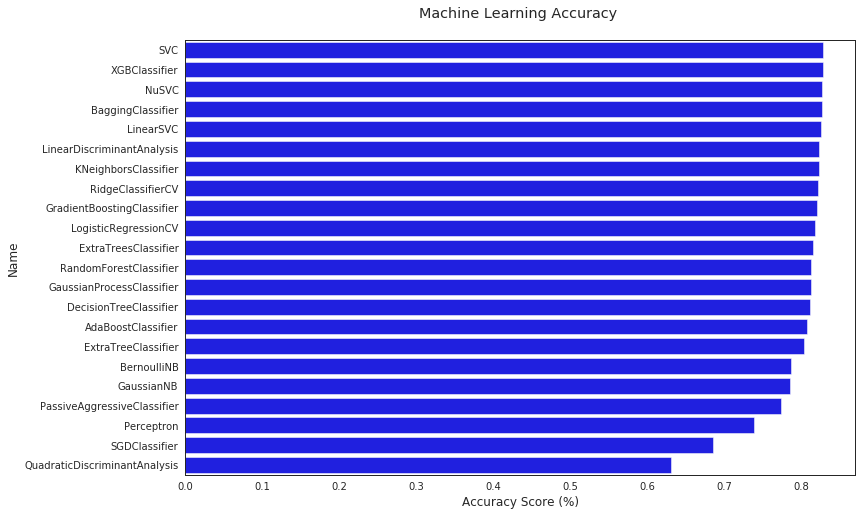

In [92]:
# Plot results
sns.barplot(x='Test Accuracy (Mean)', y='Name', data = MLA_compare, color = 'b')
plt.title('Machine Learning Accuracy \n')
plt.xlabel('Accuracy Score (%)')

In [93]:
# Test removal of single feature
# See if dropping any one feature improves score
scores=pd.DataFrame()
MLA_mod = [    
    svm.SVC(probability=True),
    XGBClassifier(),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    discriminant_analysis.LinearDiscriminantAnalysis(),
    neighbors.KNeighborsClassifier(),
    linear_model.RidgeClassifierCV(),
    ensemble.BaggingClassifier(),
    ensemble.GradientBoostingClassifier(),
    linear_model.LogisticRegressionCV() 
]
n=0
while n<len(features):
    temp_features = features[:]
    removed = temp_features.pop(n)
    
    # Test all MLA methods in list
    for alg in MLA_mod:
        MLA_name = alg.__class__.__name__
        cv_results = model_selection.cross_validate(alg, X, y, cv = cv_split)
        scores.loc[MLA_name, removed] = cv_results['test_score'].mean()
    n += 1
scores

,Pclass,SibSp,Parch,Family,Alone,Sex_Code,AgeBin_Code,FareBin_Code,Embarked_C,Embarked_Q,Embarked_S,Title_Crew,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Royalty
SVC,0.828358,0.828358,0.828358,0.828358,0.828358,0.828358,0.828358,0.828358,0.828358,0.828358,0.828358,0.828358,0.828358,0.828358,0.828358,0.828358,0.828358
XGBClassifier,0.827985,0.827985,0.827985,0.827985,0.827985,0.827985,0.827985,0.827985,0.827985,0.827985,0.827985,0.827985,0.827985,0.827985,0.827985,0.827985,0.827985
NuSVC,0.827239,0.827239,0.827239,0.827239,0.827239,0.827239,0.827239,0.827239,0.827239,0.827239,0.827239,0.827239,0.827239,0.827239,0.827239,0.827239,0.827239
LinearSVC,0.826119,0.825746,0.826119,0.825746,0.826119,0.826119,0.826119,0.826493,0.826119,0.826493,0.826119,0.826119,0.825746,0.826119,0.826119,0.826119,0.826119
LinearDiscriminantAnalysis,0.822761,0.822761,0.822761,0.822761,0.822761,0.822761,0.822761,0.822761,0.822761,0.822761,0.822761,0.822761,0.822761,0.822761,0.822761,0.822761,0.822761
KNeighborsClassifier,0.822388,0.822388,0.822388,0.822388,0.822388,0.822388,0.822388,0.822388,0.822388,0.822388,0.822388,0.822388,0.822388,0.822388,0.822388,0.822388,0.822388
RidgeClassifierCV,0.821642,0.821642,0.821642,0.821642,0.821642,0.821642,0.821642,0.821642,0.821642,0.821642,0.821642,0.821642,0.821642,0.821642,0.821642,0.821642,0.821642
BaggingClassifier,0.815299,0.830597,0.817164,0.817164,0.823881,0.817164,0.821269,0.815299,0.814552,0.820522,0.816045,0.817537,0.820522,0.818284,0.817910,0.819776,0.822388
GradientBoostingClassifier,0.820522,0.819776,0.820149,0.819776,0.819776,0.819776,0.819776,0.819403,0.820149,0.819776,0.820149,0.819776,0.819403,0.820149,0.820149,0.819776,0.820149
LogisticRegressionCV,0.817910,0.817910,0.817910,0.817910,0.817910,0.817910,0.817910,0.817910,0.817910,0.817910,0.817910,0.817910,0.817910,0.817910,0.817910,0.817910,0.817910


In [94]:
scores.describe()

,Pclass,SibSp,Parch,Family,Alone,Sex_Code,AgeBin_Code,FareBin_Code,Embarked_C,Embarked_Q,Embarked_S,Title_Crew,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Royalty
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.823022,0.824440,0.823172,0.823097,0.823806,0.823134,0.823545,0.822948,0.822910,0.823507,0.823060,0.823172,0.823396,0.823284,0.823246,0.823396,0.823694
std,0.004408,0.004145,0.004101,0.004104,0.003561,0.004133,0.003649,0.004523,0.004581,0.003740,0.004293,0.004074,0.003723,0.003930,0.003984,0.003781,0.003545
min,0.815299,0.817910,0.817164,0.817164,0.817910,0.817164,0.817910,0.815299,0.814552,0.817910,0.816045,0.817537,0.817910,0.817910,0.817910,0.817910,0.817910
25%,0.820802,0.821828,0.820522,0.820243,0.821828,0.820243,0.821362,0.819963,0.820522,0.820802,0.820522,0.820243,0.820802,0.820522,0.820522,0.820243,0.821828
50%,0.822575,0.824254,0.822575,0.822575,0.823321,0.822575,0.822575,0.822575,0.822575,0.822575,0.822575,0.822575,0.822575,0.822575,0.822575,0.822575,0.822575
75%,0.826959,0.827799,0.826959,0.826866,0.826959,0.826959,0.826959,0.827052,0.826959,0.827052,0.826959,0.826959,0.826866,0.826959,0.826959,0.826959,0.826959
max,0.828358,0.830597,0.828358,0.828358,0.828358,0.828358,0.828358,0.828358,0.828358,0.828358,0.828358,0.828358,0.828358,0.828358,0.828358,0.828358,0.828358


# Model Selection

In [95]:
# Best Model
final_model = svm.SVC(probability=True)

final_name = final_model.__class__.__name__
print('Selected Model: ', final_name)

Selected Model:  SVC


In [96]:
# Confusion Matrix Plotting Function
import itertools
def plot_confusion_matrix(cm, classes, 
                          normalize = False, title = 'Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print ('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix (not normalized)')
    print(cm)
    
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt), 
                horizontalalignment = 'center',
                color= 'white' if cm[i,j]>thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted')

Confusion Matrix (not normalized)
[[492  57]
 [ 91 251]]
Normalized Confusion Matrix
[[0.9  0.1 ]
 [0.27 0.73]]


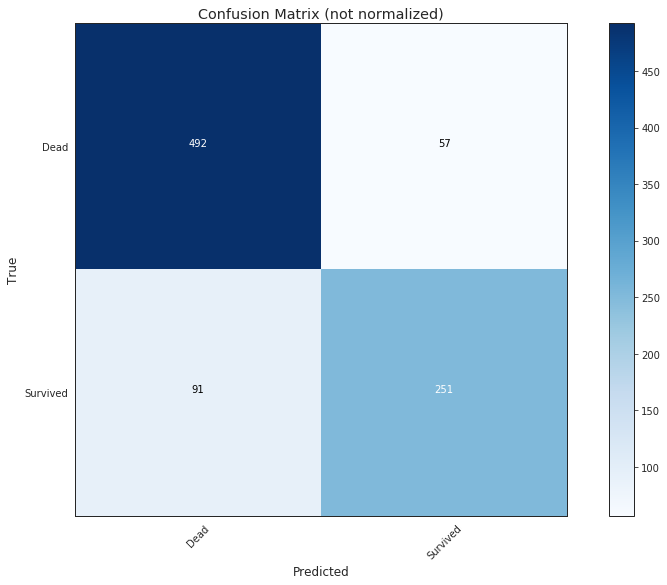

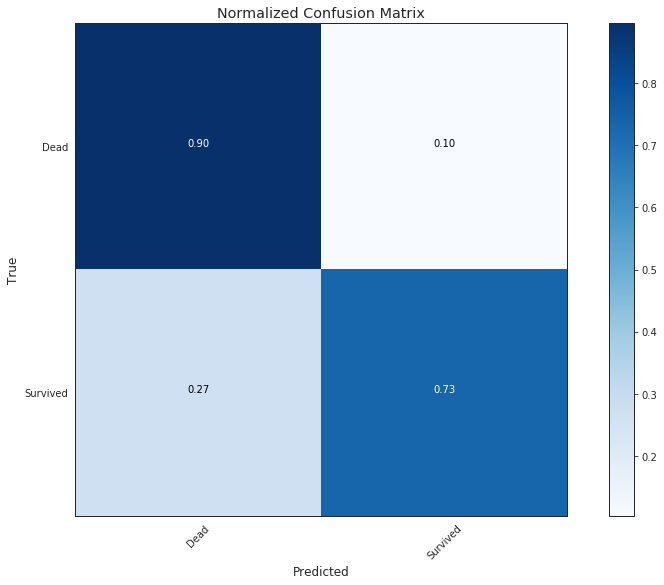

In [97]:
cnf_matrix = metrics.confusion_matrix(MLA_predict['Survived'], MLA_predict[final_name])
np.set_printoptions(precision=2)
class_names = ['Dead','Survived']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix (not normalized)')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized Confusion Matrix')

In [98]:
# Apply final model to validation set
final_model.fit(X, y)
df_val['Survived'] = final_model.predict(df_val[features])
df_val['PassengerId'] = val_IDs
df_submit = df_val[['PassengerId','Survived']]
df_submit.to_csv("../working/results.csv", index=False)

print('Results: \n', df_submit['Survived'].value_counts(normalize = True))
df_submit.sample(10)

Results: 
 0    0.61244
1    0.38756
Name: Survived, dtype: float64


,PassengerId,Survived
312,1204,0
210,1102,0
299,1191,0
165,1057,1
356,1248,1
282,1174,1
278,1170,0
399,1291,0
44,936,1
393,1285,0
